# Mosaic Integration of RNA+ADT

In this tutorial, we demonstrate how to integrate a mosaic dataset that includes RNA and ADT data. The goal is to perform data integration and imputation, then evaluate the imputed counts by calculating the Pearson's correlation coefficient (r) between the predicted imputed counts and the ground-truth counts.

## Step 1: Downloading the Demo Data

In [ ]:
from scmidas.data import download_data
download_data('wnn_mosaic_3batch', './')

## Step 2: Setting Up the Environment

Before we begin, ensure that the required environment is set up. This includes importing the necessary packages and dependencies.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

from scmidas.config import load_config
from scmidas.model import MIDAS
from scmidas.utils import load_predicted
import lightning as L

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sc.set_figure_params(figsize=(4, 4))

## Step 3: Configuring the Model

In this step, we configure the model for our dataset.

In [ ]:
configs = load_config() # load basic configurations

In [ ]:
task = 'wnn_mosaic_3batch'
model = MIDAS.configure_data_from_dir(configs, './dataset/'+task+'/data')

INFO:root:Input data: 
         #CELL    #RNA   #ADT  #VALID_RNA  #VALID_ADT
BATCH 0   6378  3617.0    NaN      3617.0         NaN
BATCH 1   6952     NaN  224.0         NaN       224.0
BATCH 2   8908  3617.0  224.0      3617.0       224.0


## Step 4: Training the Model (~3.5h)

After configuring the model, we proceed with training. This step typically takes around 3.5 hours using a single V100 GPU, depending on your system's specifications. If you prefer a quicker result, you can set `max_epochs=500` for a reasonable outcome, instead of the default `max_epochs=2000` for the best result.

In [4]:
trainer = L.Trainer(max_epochs=2000)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
trainer.fit(model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 8.2 M  | train
1 | dsc  | Discriminator | 39.0 K | train
-----------------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.817    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode
INFO:root:Total number of samples: 22238 from 3 datasets.
INFO:root:Using MultiBatchSampler for data loading.
/root/anaconda3/envs/pl/lib/python3.12/site-packages/torch/utils/data/sampler.py:76: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(
INFO:root:DataLoader created with batch size 256 and 20 workers.


Epoch 500: 100%|██████████| 105/105 [00:05<00:00, 18.01it/s, v_num=8, loss_/recon_loss_step=1.27e+3, loss_/kld_loss_step=56.30, loss_/consistency_loss_step=0.000, loss/net_step=1.27e+3, loss/dsc_step=49.40, loss_/recon_loss_epoch=1.48e+3, loss_/kld_loss_epoch=72.70, loss_/consistency_loss_epoch=17.00, loss/net_epoch=1.51e+3, loss/dsc_epoch=56.40]

INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch500_20241217-030941.pt".
INFO:root:Checkpoint saved for epoch "500" at "./saved_models/model_epoch500_20241217-030941.pt".


Epoch 1000: 100%|██████████| 105/105 [00:06<00:00, 15.33it/s, v_num=8, loss_/recon_loss_step=2.45e+3, loss_/kld_loss_step=95.80, loss_/consistency_loss_step=36.80, loss/net_step=2.51e+3, loss/dsc_step=67.40, loss_/recon_loss_epoch=1.46e+3, loss_/kld_loss_epoch=69.40, loss_/consistency_loss_epoch=15.10, loss/net_epoch=1.49e+3, loss/dsc_epoch=55.00]

INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch1000_20241217-040044.pt".
INFO:root:Checkpoint saved for epoch "1000" at "./saved_models/model_epoch1000_20241217-040044.pt".


Epoch 1500: 100%|██████████| 105/105 [00:06<00:00, 16.22it/s, v_num=8, loss_/recon_loss_step=2.43e+3, loss_/kld_loss_step=95.60, loss_/consistency_loss_step=36.00, loss/net_step=2.49e+3, loss/dsc_step=66.80, loss_/recon_loss_epoch=1.45e+3, loss_/kld_loss_epoch=68.50, loss_/consistency_loss_epoch=15.20, loss/net_epoch=1.48e+3, loss/dsc_epoch=55.30]

INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch1500_20241217-045310.pt".
INFO:root:Checkpoint saved for epoch "1500" at "./saved_models/model_epoch1500_20241217-045310.pt".


Epoch 1999: 100%|██████████| 105/105 [00:05<00:00, 17.61it/s, v_num=8, loss_/recon_loss_step=2.41e+3, loss_/kld_loss_step=95.70, loss_/consistency_loss_step=35.00, loss/net_step=2.47e+3, loss/dsc_step=69.20, loss_/recon_loss_epoch=1.44e+3, loss_/kld_loss_epoch=68.30, loss_/consistency_loss_epoch=12.90, loss/net_epoch=1.46e+3, loss/dsc_epoch=54.60]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 105/105 [00:05<00:00, 17.58it/s, v_num=8, loss_/recon_loss_step=2.41e+3, loss_/kld_loss_step=95.70, loss_/consistency_loss_step=35.00, loss/net_step=2.47e+3, loss/dsc_step=69.20, loss_/recon_loss_epoch=1.44e+3, loss_/kld_loss_epoch=68.30, loss_/consistency_loss_epoch=12.90, loss/net_epoch=1.46e+3, loss/dsc_epoch=54.60]


INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch2000_20241217-054513.pt".
INFO:root:Checkpoint saved for epoch "2000" at ./saved_models/model_epoch2000_20241217-054513.pt".


## Step 5: Predicting

Once the model is trained, we can run `predict()` to obtain various outputs from MIDAS.

In [ ]:
model.predict('./predict/'+task,         
        joint_latent=True,
        mod_latent=True,
        impute=True,
        batch_correct=True,
        translate=True,
        input=True)

## Outputs: Joint Embeddings

In this step, we explore the various outputs generated by MIDAS.
First, we load the cell-type and batch index labels associated with the dataset.

In [ ]:
label = []
batch_id = []
for i in ['p1_0', 'p5_0', 'p8_0']:
    label.append(pd.read_csv('./dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten())
    batch_id.append([i] * len(label[-1]))
labels = np.concatenate(label)
batch_ids = np.concatenate(batch_id)

The joint embeddings consist of two components: biological information (c) and technical information (u).
To analyze them, we split the embeddings and visualize them separately.

INFO:root:Loading predicted variables ...
INFO:root:Loading batch 0: z, joint
100%|██████████| 25/25 [00:00<00:00, 279.39it/s]
INFO:root:Loading batch 1: z, joint
100%|██████████| 28/28 [00:00<00:00, 324.17it/s]
INFO:root:Loading batch 2: z, joint
100%|██████████| 35/35 [00:00<00:00, 273.56it/s]
INFO:root:Converting to numpy ...
INFO:root:Converting batch 0: s, joint
INFO:root:Converting batch 0: z, joint
INFO:root:Converting batch 1: s, joint
INFO:root:Converting batch 1: z, joint
INFO:root:Converting batch 2: s, joint
INFO:root:Converting batch 2: z, joint
/root/anaconda3/envs/pl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
... storing 'batch' as categorical
... storing 'label' as categorical


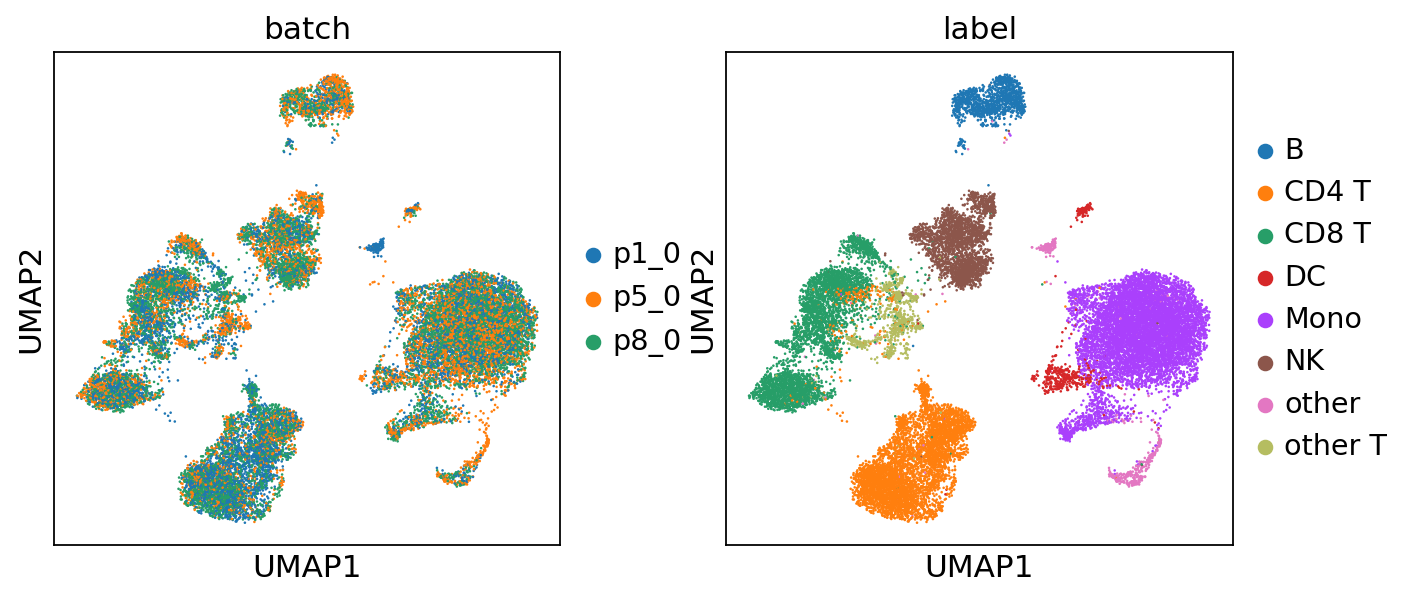

... storing 'batch' as categorical
... storing 'label' as categorical


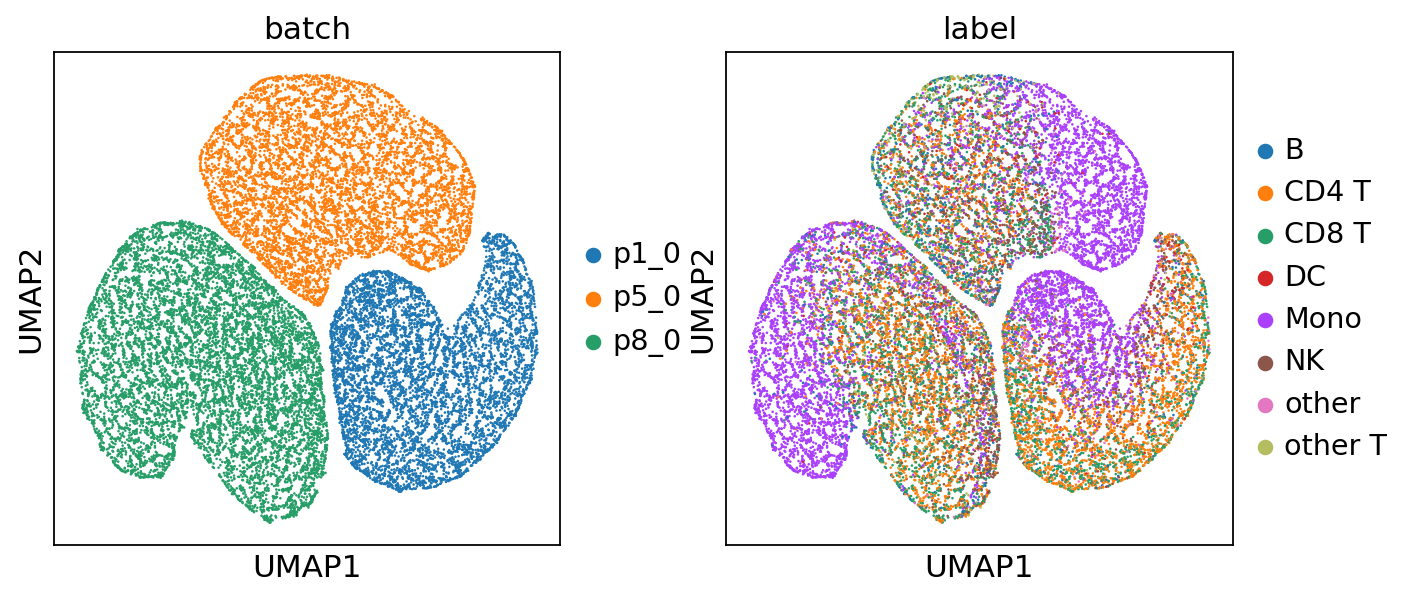

In [ ]:
joint_embeddings = load_predicted('./predict/'+task, model.combs, joint_latent=True)

adata_bio = sc.AnnData(joint_embeddings['z']['joint'][:, :model.dim_c])
adata_tech = sc.AnnData(joint_embeddings['z']['joint'][:, model.dim_c:])

adata_bio.obs['batch'] = batch_ids
adata_bio.obs['label'] = labels
adata_tech.obs['batch'] = batch_ids
adata_tech.obs['label'] = labels

for adata in [adata_bio, adata_tech]:
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    # shuffle
    sc.pp.subsample(adata, fraction=1)
    sc.pl.umap(adata, color=['batch', 'label'], ncols=2)

## Outputs: Modality-specific Embeddings

Here, we check the alignment among modalities by visualizing them with UMAP.

In [ ]:
mod_embeddings = load_predicted('./predict/'+task, model.combs,  mod_latent=True, group_by='batch')
batch_names = ['p1_0', 'p5_0', 'p8_0']
adata_list = []
for i in range(model.dims_s['joint']):
    for m in model.mods+['joint']:
        if m in mod_embeddings[i]['z']:
            adata = sc.AnnData(mod_embeddings[i]['z'][m][:, :model.dim_c])
            adata.obs['batch'] = batch_names[i]
            adata.obs['modality'] = m
            adata.obs['label'] = label[i]
            adata_list.append(adata)
adata_mod_concat = sc.concat(adata_list)
for i in adata_mod_concat.obs:
    adata_mod_concat.obs[i] = adata_mod_concat.obs[i].astype('category')
sc.pp.neighbors(adata_mod_concat)
#shuffle
sc.pp.subsample(adata_mod_concat, fraction=1)
sc.tl.umap(adata_mod_concat)

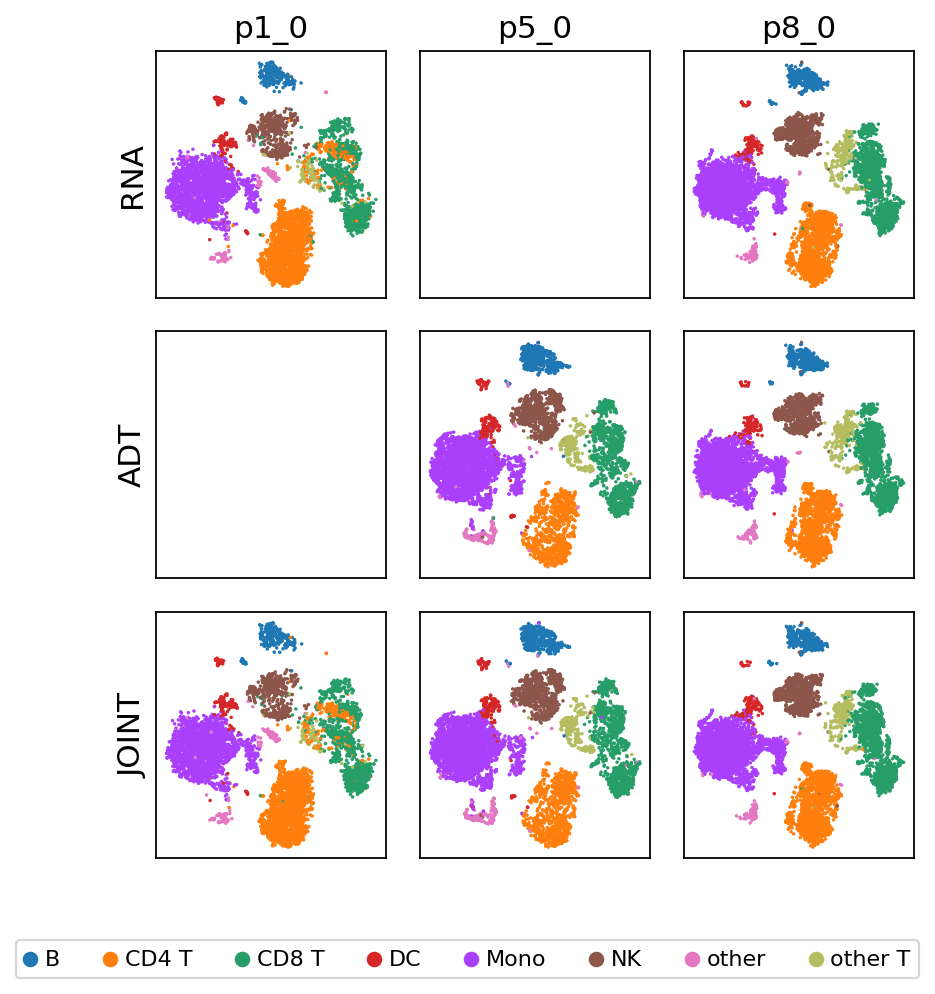

In [10]:
# setup figure
nrows = len(model.mods) + 1
ncols = model.dims_s['joint']
point_size = 10

fig, ax = plt.subplots(nrows, ncols, figsize=[2 * ncols, 2 * nrows])

# set up the name of modalities and batch
mod_names = model.mods + ['joint']

# iteratively scatter the data
for i, mod in enumerate(mod_names):
    for b in range(model.dims_s['joint']):
        # filter data
        adata = adata_mod_concat[
            (adata_mod_concat.obs['modality'] == mod) & 
            (adata_mod_concat.obs['batch'] == batch_names[b])
        ].copy()
        if len(adata):
            sc.pl.umap(adata, color='label', show=False, ax=ax[i, b], s=point_size)
            ax[i, b].get_legend().set_visible(False)
            handles, labels_ = ax[i, b].get_legend_handles_labels()
        ax[i, b].set_xticks([])
        ax[i, b].set_yticks([])
        ax[i, b].set_xlabel('')
        if b==0:
            ax[i, b].set_ylabel(mod.upper())
        else:
            ax[i, b].set_ylabel('')
        if i==0:
            ax[i, b].set_title(batch_names[b])
        else:
            ax[i, b].set_title('')
# create global legend
fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels_), fontsize=10)

# adjust the figure
plt.tight_layout(rect=[0.1, 0.05, 1, 1])
plt.show()

## Outputs: Imputed Counts

Since this dataset is a mosaic dataset, we retrieve the imputed counts, which are the completed counts. We calculat pearson's r between the imputed data and the ground-truth data.

In [ ]:
imputed = load_predicted('./predict/'+task, model.combs, impute=True)

Calculate similarity.

In [ ]:
ref_adt = pd.read_csv('./dataset/'+task+'/data/p1_0/mat/adt.csv', index_col=0).values
print('Pearson\'s r for ADT (p1_0)', pearsonr(ref_adt.reshape(-1), imputed['x_impt']['adt'][:6378].reshape(-1))[0])

Pearson's r for ADT (p1_0) 0.8608445224365799


In [ ]:
ref_rna = pd.read_csv('./dataset/'+task+'/data/p5_0/mat/rna.csv', index_col=0).values
print('Pearson\'s for RNA (p5_0)', pearsonr(ref_rna.reshape(-1), imputed['x_impt']['rna'][6378:(6378+6952)].reshape(-1))[0])

Pearson's for RNA (p5_0) 0.9249721667452995


## Outputs: Batch-corrected Counts

In [ ]:
batch_corrected_counts = load_predicted('./predict/'+task, model.combs, batch_correct=True)

Save the data to CSV files for later use in R.

In [ ]:
pd.DataFrame(batch_corrected_counts['x_bc']['rna']).T.to_csv('temp_rna.csv', index=True)
pd.DataFrame(batch_corrected_counts['x_bc']['adt']).T.to_csv('temp_adt.csv', index=True)

PCA+WNN

In [ ]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
importr('Seurat')
importr('SeuratDisk')
importr('dplyr')
importr('Signac')
ro.r('''
rna <- read.csv('./temp_rna.csv', header=TRUE, row.names=1)
adt <- read.csv('./temp_adt.csv', header=TRUE, row.names=1)
obj <- CreateSeuratObject(counts = rna, assay = "rna")
obj[["adt"]] <- CreateAssayObject(counts = adt)
obj <- subset(obj, subset = nCount_rna > 0 & nCount_adt > 0)
print(obj)
DefaultAssay(obj) <- 'rna'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_rna", verbose = F)
print('finish rna')
DefaultAssay(obj) <- 'adt'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_adt", verbose = F)
print('finish adt')
print('WNN ...')
obj <- FindMultiModalNeighbors(obj, list("pca_rna", "pca_adt"), list(1:32, 1:32))
obj <- RunUMAP(obj, nn.name = "weighted.nn", reduction.name = "umap")
''')

... storing 'label' as categorical
... storing 'batch' as categorical


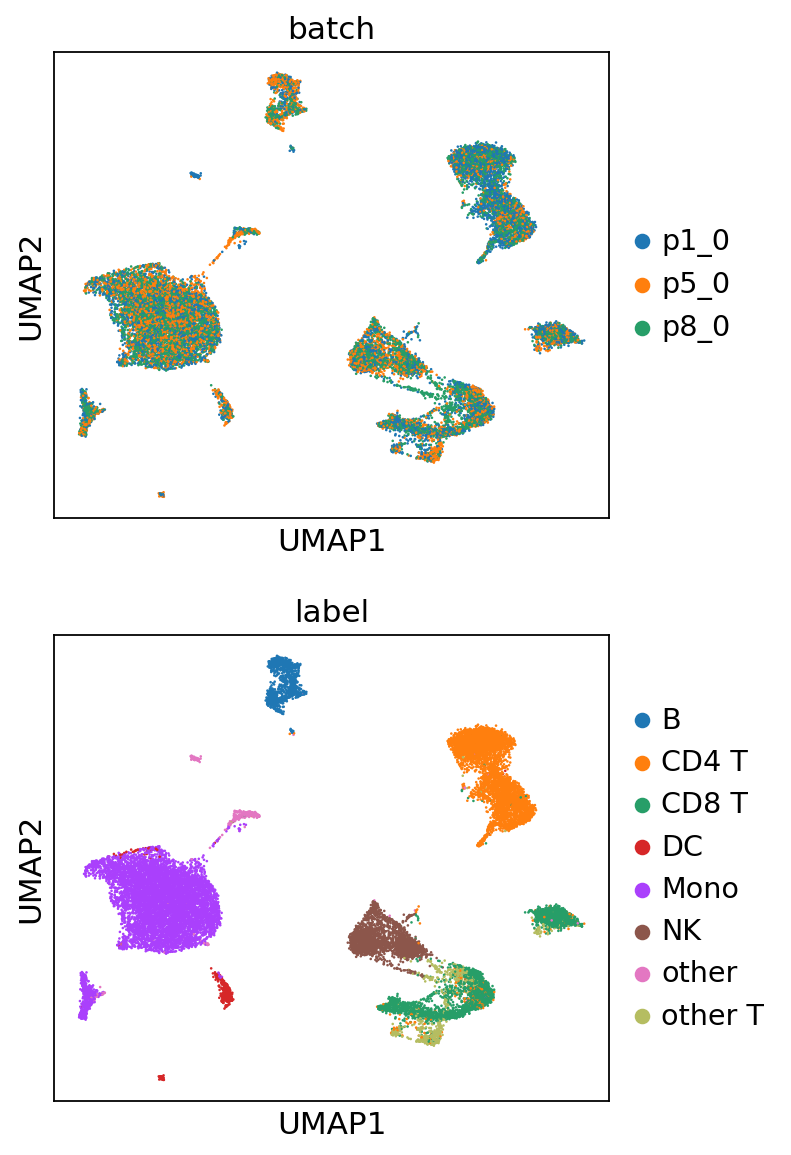

In [ ]:
# Create an AnnData object with 'X' not being used, so we initialize it with all zeros
adata = sc.AnnData(np.zeros([len(batch_corrected_counts['x_bc']['rna']), 1]))
adata.obs['label'] = labels
adata.obs['batch'] = batch_ids
f = ro.r('''DimPlot(obj, reduction='umap')''')
adata.obsm['umap'] = pd.DataFrame(f[0]).iloc[:2].T.values
# shuffle
sc.pp.subsample(adata, fraction=1)
sc.pl.umap(adata, color=['batch', 'label'], ncols=1)